In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import scipy as sc
import math
import random

In [2]:
# Defining All Variables Needed Below
# Constants
A = 0.84237  # Hamaker constant (eV) (5nm gold in water)
R = 2.5  # Nanoparticle radius (nm)
T = 313  # Temperature (K)
kb = 8.617e-5  # Boltzmann constant (eV/K)
rho_inf = 7.2e+5  # Number density of ions in bulk (nm^-3) Ions come from ionization of DDT
psi = 0.15  # Surface potential (eV) Estimated by ChatGPT
e0 = .055263  # Vacuum permittivity (e^2/(eV*nm))
er = 150  # Relative permittivity of water
e = 1  # Elementary charge
z = 1  # Monovalent ion assumption
B = 10  # Born repulsion prefactor (adjustable)
lambda_B = 0.1  # Born repulsion decay length (nm)

ionic_strength = 1.1 # See Previous DLVO document for calculations

# bjerrum = e**2/(4*np.pi*e0*er*kb*T) #Bjerrum length

gamma = np.tanh(z*e*psi/(4*kb*T)) # reduced surfacepotential
kappa = np.sqrt(ionic_strength/(e0*er*kb*T)) # reduced surface potential

#Prefactor to be using in DLVO, outside of the function to save on runtime.
electrostatic_prefactor = (32*np.pi*kb*T*R*e**2)/(kappa**2)


sigma = .34 #(nm)
epsilon = 1.65

In [16]:
def wrap(r, L):
    return r % L

def dist(r1, r2, L):
    half_L = L / 2.0
    d_vec = (r2 - r1 + half_L) % L - half_L
    return np.sqrt(np.sum(d_vec**2))

    

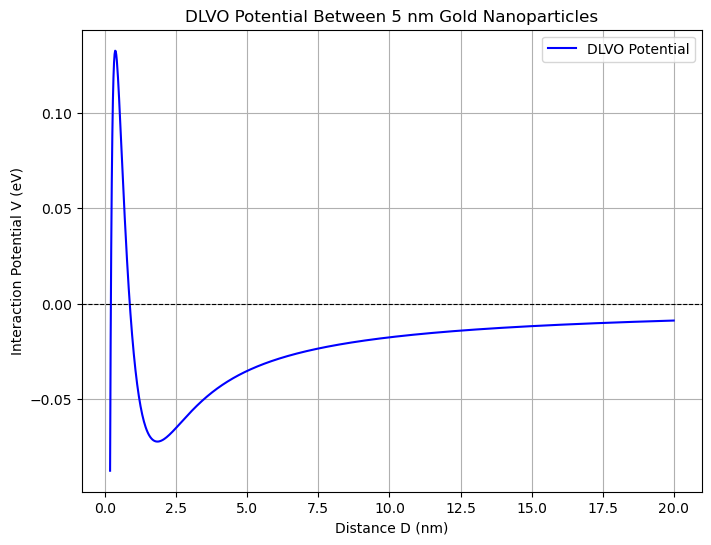

In [4]:
# DLVO Function (Our main Potential Function)
def DLVO(D):

  '''
  Returns Potential Between Two Spheres according to DLVO Theory

  Variables:
  A = hamaker constant
  R = Nanoparticle radius
  D = distance between particles (center to center)
  T = Temperature
  k = Boltzmann constant
  rho_inf = number density of ion in the bulk sample
  gamma = reduced surface potential
  kappa = inverse of the debye screening length
  '''
  # sphere-sphere Vdw interaction
  vdw_attraction = -A * R / (12 * (D))
  #Electrostatic Repulsion
  electrostatic_repulsion = electrostatic_prefactor*np.exp(-kappa*(D))
  #Born repulsion (Hard-core repulsion)
  # born_repulsion = B * np.exp(-D / lambda_B)
  return (vdw_attraction + electrostatic_repulsion) #+ born_repulsion)


# Define a range of distances from 2R (touching) to 100 nm
D_values = np.linspace(sigma/2, 20, 1000)
V_values = DLVO(D_values)

# Plot the DLVO potential
plt.figure(figsize=(8, 6))
plt.plot(D_values, V_values, label="DLVO Potential", color='b')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel("Distance D (nm)")
plt.ylabel("Interaction Potential V (eV)")
plt.title("DLVO Potential Between 5 nm Gold Nanoparticles")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
#r in this case is equal to D (and r0 is equal to D0)
def harmonic_bias(D, D0, k):
  harmonic = 0.5*(k*(D-D0)**2)
  return harmonic

In [6]:
def E_i(ri,i,xyz,L,sigma,epsilon,D0):
    N = xyz.shape[0]
    E_i = 0.
    for j in range(N):
        if j!=i:
            rj = xyz[j,:]
            d = dist(ri,rj,L)
            E_i += (DLVO(d)+harmonic_bias(d, D0, k))
    return E_i

In [7]:
def E_system(xyz,L,sigma,epsilon):

    N = xyz.shape[0]

    E = 0.

    for ii in range(N):
        r1 = xyz[ii,:]
        for jj in range(ii):
            r2 = xyz[jj,:]
            d = dist(r1,r2,L)
            E += (DLVO(d)+harmonic_bias(d, D0, k))

    return E

In [8]:
def init_rand(N,L,sigma):

    xyz = np.random.uniform(0,L,(N,3))

    for ii in range(N):
        print('  Inserting particle %d' % (ii+1))
        xyz[ii,:] = np.random.uniform(0,L,3)
        r1 = xyz[ii,:]
        collision=1
        while(collision):
            collision=0
            for jj in range(ii):
                r2 = xyz[jj,:]
                d = dist(r1,r2,L)
                if d<sigma:
                    collision=1
                    break
            if collision:
                r1 = np.random.uniform(0,L,3)
                xyz[ii,:] = r1
    print('Done!')

    # verifying all collisions resolved
    for ii in range(N):
        r1 = xyz[ii,:]
        for jj in range(ii):
            r2 = xyz[jj,:]
            d = dist(r1,r2,L)
            if d<sigma:
                raise Exception('Collision between particles %d and %d' % (ii+1,jj+1))

    return xyz

In [9]:
def define_windows(start, stop, window_width, overlap):
    windows = []
    center = start
    while (center + window_width)/ 2 < stop:
        #upper and lower bounds of each window
        lower_bound = (center - window_width) / 2
        upper_bound = (center + window_width) / 2
        windows.append((lower_bound, upper_bound))

        center += window_width - overlap
    return windows
#for example: windows = define_windows(1.0, 3.0, window_width=1.0, overlap=0.5)
#if we want to define the windows to span over distances of 1nm to 3 nm

In [10]:
T = 298 #K -- temperature
L = 100 #nm -- cubic box side length
N = 50 #number of atoms -- we can change
nSweeps = 750 #number of MC sweeps (1 sweep = N single particle moves)
dispSize = 1 #nm -- characteristic size of atomic displacement trial moves
printModulus = 1 #sweeps -- frequency of prints to screen
writeModulus = 10 #sweeps -- frequency of writes to file
k = 1.7 #eV/nm^2 but we can also change this, its just a starting point

In [11]:
def proposed_move(r_vals, L, window):
    #randomly selecting a particle to move and adjust its position
    particle = random.randint(0, len(r_vals) - 1)
    r_old = r_vals[particle]
    r_new = r_old + np.random.uniform(-0.1, 0.1)  #Small random step
    r_new = np.clip(r_new, 0, L)

    if window[0] <= r_new <= window[1]:
        return r_new, particle, True
    else:
        return r_old, particle, False

In [12]:
def xyzWrite(xyz,outfile,writeStyle):
    xyzfile = open('./'+outfile, writeStyle)

    xyzfile.write('%d\n' % N)
    xyzfile.write('\n')
    for ii in range(N):
        xyzfile.write('%5s %8.5e %8.5e %8.5e\n' % ('Ar',xyz[ii,0]*10,xyz[ii,1]*10,xyz[ii,2]*10)) # Angstroms

    xyzfile.close()

In [13]:
# initializing atomic positions and writing to file
#xyz = init_xtal(N,L)
xyz = init_rand(N,L,sigma)

xyzWrite(xyz,'init.xyz', 'w')
xyzWrite(xyz,'traj.xyz', 'w')

  Inserting particle 1
  Inserting particle 2
  Inserting particle 3
  Inserting particle 4
  Inserting particle 5
  Inserting particle 6
  Inserting particle 7
  Inserting particle 8
  Inserting particle 9
  Inserting particle 10
  Inserting particle 11
  Inserting particle 12
  Inserting particle 13
  Inserting particle 14
  Inserting particle 15
  Inserting particle 16
  Inserting particle 17
  Inserting particle 18
  Inserting particle 19
  Inserting particle 20
  Inserting particle 21
  Inserting particle 22
  Inserting particle 23
  Inserting particle 24
  Inserting particle 25
  Inserting particle 26
  Inserting particle 27
  Inserting particle 28
  Inserting particle 29
  Inserting particle 30
  Inserting particle 31
  Inserting particle 32
  Inserting particle 33
  Inserting particle 34
  Inserting particle 35
  Inserting particle 36
  Inserting particle 37
  Inserting particle 38
  Inserting particle 39
  Inserting particle 40
  Inserting particle 41
  Inserting particle 42
 

In [14]:
windows = define_windows(10, 50, window_width=0.5, overlap=0.1) #im defining the lower bound to be 10nm (=2R) and the upper to be 50 nm, so
                                                                #we should adjust box size to fit...

E_traj = []
trial_counter = 0
acc_counter = 0

for sweep in range(nSweeps):
    print('MC sweep %d' % (sweep + 1))

    for ii in range(N):
        #defines the umbrella sampling window for the chosen particle (using one of the two defined umbrella sampling code chunks)
        window = random.choice(windows)  #randomly picks a window for biasing
        D0 = (window[0] + window[1])/2

        tag = np.random.randint(0, N)
        xyz_tag_old = xyz[tag, :]
        E_tag_old = E_i(xyz_tag_old, tag, xyz, L, sigma, epsilon,D0)


        #Harmonic biasing potential at the current position
        D_old = np.linalg.norm(xyz_tag_old)  #Distance between particles (replace with appropriate logic)
        old_harmonic_bias = harmonic_bias(D_old, D0, k)  #Harmonic bias at old position

        #trial move
        xyz_tag_new = xyz_tag_old + (dispSize*np.random.uniform(-1, 1, 3))
        xyz_tag_new_wrap = wrap(xyz_tag_new, L)
        E_tag_new = E_i(xyz_tag_new_wrap, tag, xyz, L, sigma, epsilon, D0)  #energy at new position

        #harmonic biasing potential at the new position
        D_new = dist(xyz_tag_new_wrap, xyz_tag_new_wrap, L)  #new distance after the move
        new_harmonic_bias = harmonic_bias(D_new, D0, k)  #harmonic bias at new position

        #acceptance criterion
        deltaE = E_tag_new + new_harmonic_bias - E_tag_old - old_harmonic_bias

        if deltaE < 0:
            xyz[tag, :] = xyz_tag_new_wrap
            acc_counter += 1
        else:
            if T > 0:
                if np.random.random() < np.exp(-deltaE / (kb * T)):  #acceptance
                    xyz[tag, :] = xyz_tag_new_wrap  #Accept the move
                    acc_counter += 1

        trial_counter += 1

    # Print statistics every few sweeps
    if (sweep + 1) % printModulus == 0:
        E = E_system(xyz, L, sigma, epsilon)  # Total system energy
        E_traj.append(E)
        print('  E = %12.5e zJ' % E)
        if trial_counter > 0:
            print('  acceptance ratio = %12.5e' % (float(acc_counter) / float(trial_counter)))
        else:
            print('  acceptance ratio = %12.5e' % 0)

    # Write trajectory to file every few sweeps
    if (sweep + 1) % writeModulus == 0:
        xyzWrite(xyz, 'traj.xyz', 'a')

MC sweep 1
  E =  1.08015e+06 zJ
  acceptance ratio =  9.60000e-01
MC sweep 2
  E =  3.12265e+05 zJ
  acceptance ratio =  9.20000e-01
MC sweep 3
  E =  2.09885e+05 zJ
  acceptance ratio =  9.20000e-01
MC sweep 4
  E =  9.02126e+05 zJ
  acceptance ratio =  9.25000e-01
MC sweep 5
  E =  7.39997e+05 zJ
  acceptance ratio =  9.24000e-01
MC sweep 6
  E =  1.39646e+06 zJ
  acceptance ratio =  9.03333e-01
MC sweep 7
  E =  1.20848e+06 zJ
  acceptance ratio =  9.05714e-01
MC sweep 8
  E =  2.69857e+05 zJ
  acceptance ratio =  9.07500e-01
MC sweep 9
  E =  1.61504e+06 zJ
  acceptance ratio =  9.06667e-01
MC sweep 10
  E =  2.09875e+05 zJ
  acceptance ratio =  8.98000e-01
MC sweep 11
  E =  4.55521e+05 zJ
  acceptance ratio =  8.98182e-01
MC sweep 12
  E =  2.44453e+05 zJ
  acceptance ratio =  8.95000e-01
MC sweep 13
  E =  5.52183e+05 zJ
  acceptance ratio =  8.89231e-01
MC sweep 14
  E =  3.63139e+05 zJ
  acceptance ratio =  8.87143e-01
MC sweep 15
  E =  1.97192e+06 zJ
  acceptance ratio =  8

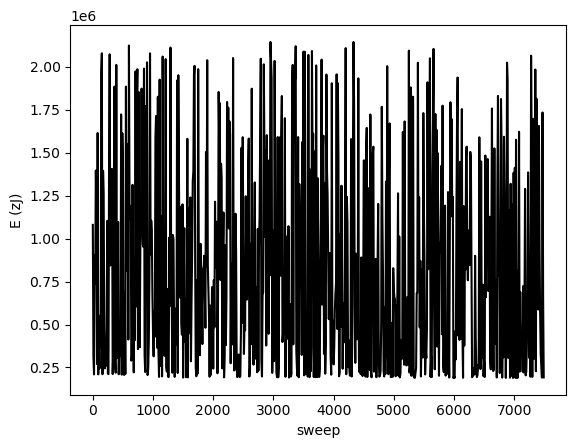

In [15]:
fig1, ax1 = plt.subplots()
ax1.plot(writeModulus * np.arange(len(E_traj)), E_traj, 'k-', marker='')
ax1.set_xlabel("sweep")
ax1.set_ylabel("E (zJ)")
plt.draw()
plt.show()